<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, LSTM, Dropout, Dense
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [2]:
drive.mount('/content/drive')
t1_markov = "drive/MyDrive/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Mounted at /content/drive


# 2º Passo: Cálculo do torque de interação τ_i

In [3]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
markov_t1['tau_i'] = Ka * (markov_t1['R_t_p'] - markov_t1['R_t_l']) + Ba * (markov_t1['R_w_p'] - markov_t1['R_w_l'])
markov_t1['d_tau_i'] = np.gradient(markov_t1['tau_i'])

# 3º Passo: Separação e Normalização dos dados


In [4]:
dataset = markov_t1.copy()
X = dataset[['tau_i', 'd_tau_i', 'phase', 'R_T']].iloc[1450:]
y = dataset[['R_T']].iloc[1450:]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [5]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (10129, 420, 4)
Forma dos dados de saída: (10129, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [20]:
model_cnn_lstm = Sequential()

# Ajustar o input_shape para refletir o número de características (4)
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, 4)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# Ajustar a saída da CNN para a entrada da LSTM
# Não alterar a dimensão calculada (209, 64)
model_cnn_lstm.add(LSTM(64, return_sequences=True))
model_cnn_lstm.add(Dropout(0.2))

model_cnn_lstm.add(LSTM(32, return_sequences=False))
model_cnn_lstm.add(Dropout(0.2))

# Camada de saída
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

# Compilação do modelo
model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['MAE', 'MSE'])

# Resumo do modelo
model_cnn_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 418, 64)             │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 209, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 209, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 209, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,305 (180.88 KB)

 Trainable params: 46,305 (180.88 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [21]:
# Treinamento do modelo
history = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=16,            # Número de épocas ajustável
    batch_size=32,        # Lote para atualização dos pesos
    validation_split=0.2, # Separação para validação
    verbose=1             # Exibição detalhada do progresso
)

Epoch 1/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 70s 257ms/step - MAE: 0.0714 - MSE: 0.0094 - loss: 0.6417 - val_MAE: 0.0306 - val_MSE: 0.0015 - val_loss: 0.6366
Epoch 2/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - MAE: 0.0324 - MSE: 0.0017 - loss: 0.6236 - val_MAE: 0.0250 - val_MSE: 0.0010 - val_loss: 0.6354
Epoch 3/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - MAE: 0.0287 - MSE: 0.0014 - loss: 0.6245 - val_MAE: 0.0213 - val_MSE: 7.7362e-04 - val_loss: 0.6349
Epoch 4/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 83s 245ms/step - MAE: 0.0254 - MSE: 0.0011 - loss: 0.6227 - val_MAE: 0.0200 - val_MSE: 6.9002e-04 - val_loss: 0.6347
Epoch 5/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - MAE: 0.0232 - MSE: 9.6998e-04 - loss: 0.6208 - val_MAE: 0.0296 - val_MSE: 0.0012 - val_loss: 0.6359
Epoch 6/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 84s 247ms/step - MAE: 0.0247 - MSE: 0.0010 - loss: 0.6228 - val_MAE: 0.0160 - val_MSE: 4.5423e-04 - val_loss: 0.6341
Epoch 7/16
254/254 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - MAE: 0.02

# 7º Passo: Avaliação e Previsão

In [22]:
y_pred_scaled = model_cnn_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

317/317 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step
R²: 0.9885187452569887
MAE: 0.2355 Nm
RMSE: 0.3215 Nm


# 8º Passo: Visualização das perdas (train vs validation)

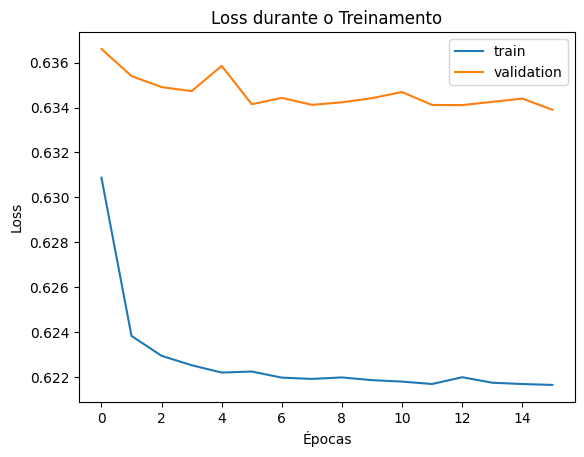

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

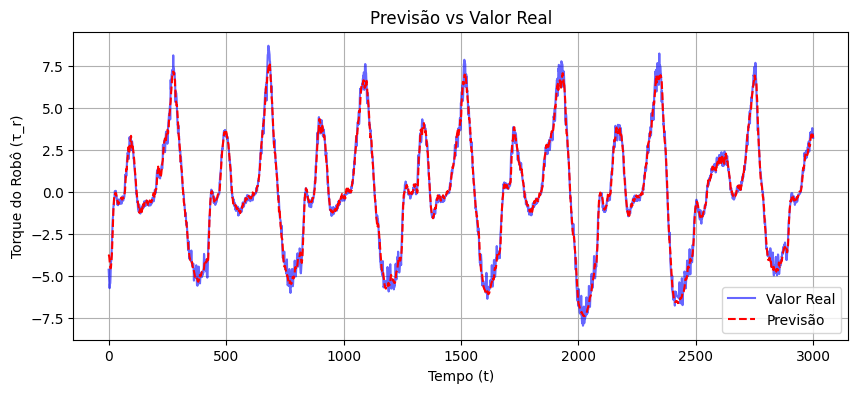

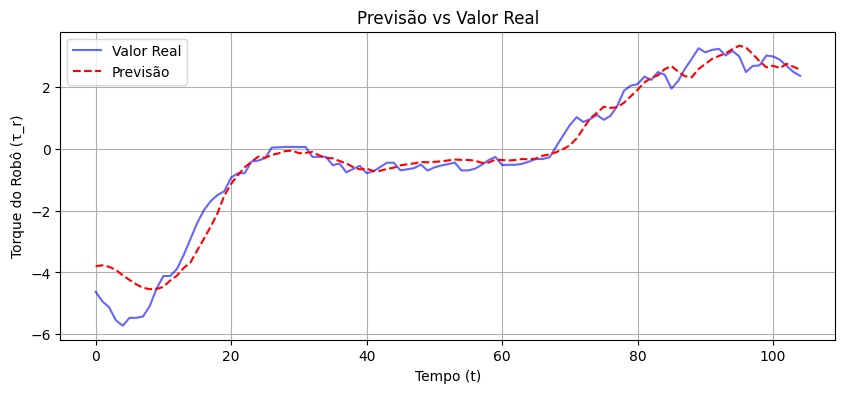

In [25]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:3000], y_pred[:3000])
plot_predictions(y_train_rescaled[:105], y_pred[:105])



# 10º Passo: Erro

In [26]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

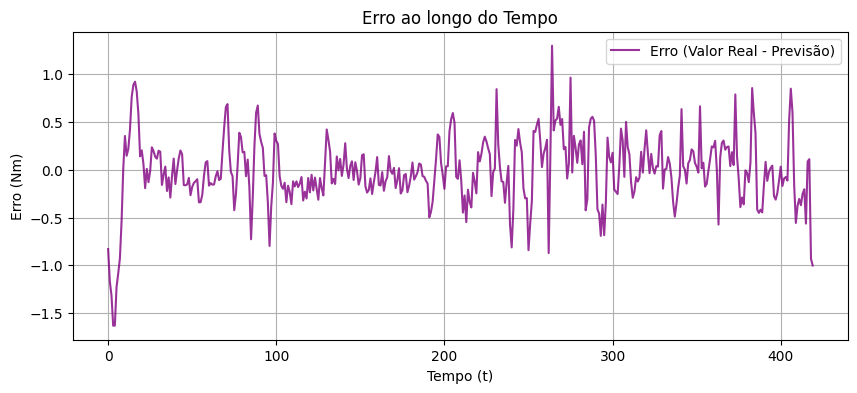

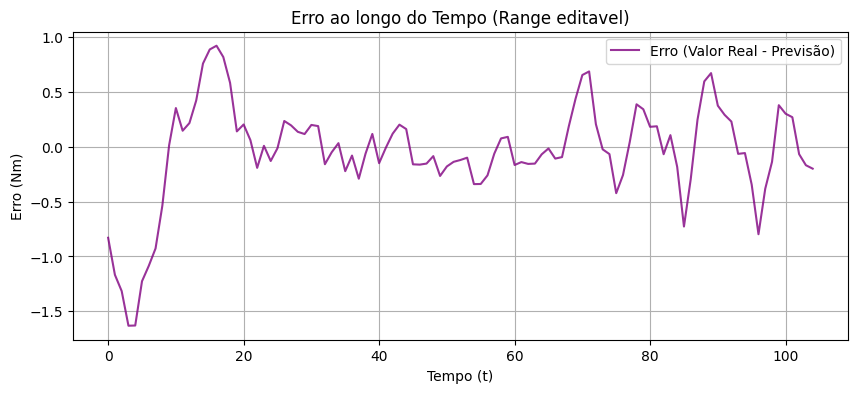

Média do Erro: 0.0164 Nm
Desvio Padrão do Erro: 0.3210 Nm


In [29]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:420], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:105], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')